In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torch import nn 
from torch import optim
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import sampler
from torch.utils.data import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt ### воспользуемся для отображения изображения
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# define transforms for normalization and data augmentation
transform_augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4)])
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
NUM_TRAIN = 45000
NUM_VAL = 5000
batch_size = 64

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./dataset_train',
                                             train=True,  
                                             transform=T.Compose([transform_augment, transform_normalize]), 
                                             download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

Files already downloaded and verified


In [6]:
test_dataset = torchvision.datasets.CIFAR10(root='./dataset_test', train=False,
                                       download=True, transform=transform_normalize)

Files already downloaded and verified


In [7]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
net = Net().to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
num_down_loss = 0
loss_bufer = 0
stat_loss = list()

for epoch in range(70):  
    running_loss_ = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].cuda(), data[1].cuda()

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
#         running_loss += loss.item()
        running_loss_ += loss.item()
        
#         if i % 1000 == 0:    # печатаем каждые 300 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 1000))
#             running_loss = 0.0
    
    running_loss_ = running_loss_ / len(train_loader)
    print(f'epoch: {epoch}. loss: {running_loss_}')
#     if loss_bufer < running_loss_:
#         num_down_loss += 1
#     else:
#         num_down_loss = 0
        
    loss_bufer = running_loss_
    stat_loss.append(running_loss_)
    running_loss_ = 0
    
#     if num_down_loss > 20:
#         print('Early stopping')
#         break  
        

print('Training is finished!')

epoch: 0. loss: 0.9397855531376647
epoch: 1. loss: 0.9370761538100669
epoch: 2. loss: 0.9292554861444342
epoch: 3. loss: 0.9257059993646334
epoch: 4. loss: 0.9273613303366219
epoch: 5. loss: 0.9238768375438192
epoch: 6. loss: 0.9203021370084085
epoch: 7. loss: 0.9155241902679434
epoch: 8. loss: 0.9186072803824149
epoch: 9. loss: 0.9150896797628354
epoch: 10. loss: 0.9154725395657523
epoch: 11. loss: 0.9122917525603643
epoch: 12. loss: 0.9074896445207279
epoch: 13. loss: 0.9064462901381276
epoch: 14. loss: 0.9010557797939881
epoch: 15. loss: 0.9061496407936906
epoch: 16. loss: 0.8974141185088536
epoch: 17. loss: 0.8986834793749368
epoch: 18. loss: 0.8901998694900357
epoch: 19. loss: 0.8879977298514617
epoch: 20. loss: 0.8909248929194478
epoch: 21. loss: 0.8862545387366848
epoch: 22. loss: 0.8892981741586914
epoch: 23. loss: 0.8886293340140902
epoch: 24. loss: 0.8838981498995095
epoch: 25. loss: 0.8838374747720825
epoch: 26. loss: 0.8780577802444662
epoch: 27. loss: 0.8816320813068038
ep

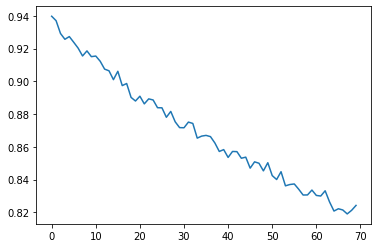

In [18]:
plt.plot(stat_loss)
plt.show()

In [19]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane
Predicted:      cat  ship  ship plane


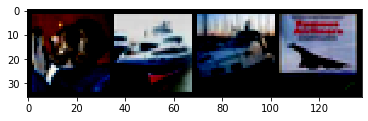

In [20]:
outputs = net(images.cuda())
imgs = torchvision.utils.make_grid(images)
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Взять часть, где мы делали один шаг обучения, и обернуть его в цикл по схеме, как обучали модель в конце занятия.

In [21]:
linear = nn.Linear(2, 2)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

x = Variable(torch.randn(2), requires_grad = True)
y = Variable(torch.randn(2), requires_grad = False)

dataset = torch.utils.data.TensorDataset(x, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, pin_memory=True)

optimizer.zero_grad()
pred = linear(x)
loss = criterion(pred, y)
print('loss: ', loss.item())

loss:  0.24399849772453308


In [22]:
for epoch in range(10):  
    running_loss = 0.0
    for i, data in enumerate(loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = linear(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'loss: {running_loss/len(loader)}')
    running_loss=0

print('Training is finished!')

loss: 0.24399849772453308
loss: 0.23897406458854675
loss: 0.2340531200170517
loss: 0.2292335033416748
loss: 0.22451308369636536
loss: 0.21988990902900696
loss: 0.21536192297935486
loss: 0.21092715859413147
loss: 0.20658376812934875
loss: 0.20232978463172913
Training is finished!


Переписать на PyTorch:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.f1 = nn.Flatten((28, 28),128)
        self.l1 = nn.Linear(128, 128)
        self.d1 = nn.Dropout(0.2)
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.f1(x)
        x = F.relu(self.l1(x))
        x = self.d1(x)
        x = F.softmax(self.l2(x))
        return x